<div class="alert alert-info">
    
➡️ Make sure that you have read the **[rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins)** and the **[policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating)** before starting with this lab.

➡️ Make sure you fill in any cells (and _only_ those cells) that say **`YOUR CODE HERE`** or **YOUR ANSWER HERE**, and do _not_ modify any of the other cells.

➡️ **Before you submit your lab, make sure everything runs as expected.** For this, _restart the kernel_ and _run all cells_ from top to bottom. In Jupyter Notebook version 7 or higher, you can do this via "Run$\rightarrow$Restart Kernel and Run All Cells..." in the menu (or the "⏩" button in the toolbar).

</div>

# L5: Large language models and text summarization

Large language models (LLMs) are deep neural networks trained on the language modelling task over massive amounts of text data.  Their strength comes from encoding text representations in a much more sophisticated way than the bag-of-words or tf–idf representations we have seen in previous labs.

In this lab, you will analyse token and sentence representations from a language model of the “BERT” family of models, which are trained on the masked language modelling objective.  The first part is about extracting and analysing representations from such a model, while the second part is about applying them to the problem of extractive text summarization. In the third part, you will use a larger, autoregressive language model to perform abstractive text summarization.

In [9]:
# Define some helper functions that are used in this notebook

%matplotlib inline
from IPython.display import display, HTML

def success():
    display(HTML('<div class="alert alert-success"><strong>Solution appears correct!</strong></div>'))

## Data set for embedding analysis

We have prepared a data set containing a small sample of sentences from DBpedia, each containing the word _record_.

In [10]:
import pandas as pd
import numpy as np
import bz2

with bz2.open("dbpedia_record_sample.json.bz2", "rt", encoding="utf-8") as f:
    df = pd.read_json(f)

There are two labelled columns in the data set: `sentence` (the sentence from DBpedia), and `label` (the category of the DBpedia entry where the sentence is from).  The `label` column can take three values: Company, Album, or Athlete. 

In [11]:
pd.set_option('display.max_colwidth', None)
df.head()

,sentence,label
0,Polar Music is a Swedish record company founded in 1963 by Stig Anderson and his friend Bengt Bernhag.,Company
1,Promotone BV is the record label of the Rolling Stones.,Company
2,Southern Lord Records is an American independent record label founded by Greg Anderson in 1998.,Company
3,Glasgow Underground Recordings is a house music record label owned by Kevin McKay.,Company
4,Oriental Star Agencies is a British based record label based in the Balsall Heath area of Birmingham.,Company


Let's use the following sentence as an example:

In [12]:
sentence = df.loc[8, "sentence"] # 'Mute is a British record label.'
sentence

'Mute is a British record label.'

## Problem 1: Contextualized word embeddings

In the first problem, you will extract and analyze contextualized word embeddings from a small BERT model.

BERT is a transformer model trained on the masked language modelling objective.  There are many pre-trained variants of this model; we will be using `bert-tiny`, which is the smallest version of BERT available on the Huggingface Model Hub.  The following cell instantiates the model and its tokenizer using PyTorch and the Huggingface Transformers library:

In [13]:
import torch
from transformers import AutoTokenizer, AutoModel

model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Let's try out how the tokenizer works by running our example sentence through it:

In [14]:
tokenizer(sentence)

{'input_ids': [101, 20101, 2003, 1037, 2329, 2501, 3830, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

The list under `input_ids` contains a numerical ID for each token in the original sentence.  (You can ignore the other entries for the purposes of this lab.)  Which tokens do these numbers correspond to?  One way to see this is to call the `.convert_ids_to_tokens()` method, which converts the IDs back to tokens:

In [15]:
input_ids = tokenizer(sentence)["input_ids"]
tokenizer.convert_ids_to_tokens(input_ids)

['[CLS]', 'mute', 'is', 'a', 'british', 'record', 'label', '.', '[SEP]']

We can see a few things here:
- The model lowercases all tokens, i.e., it does not distinguish between _record_ and _Record_.
- The sentence is “framed” by two “special” tokens, `[CLS]` and `[SEP]`, which are automatically inserted by the tokenizer.

Before you continue, inspect the output above and consider which numerical ID the token _record_ corresponds to.  You can confirm your answer by inspecting the tokenizer's vocabulary:

In [16]:
tokenizer.vocab["record"]

2501

Now that we have inspected the tokenizer, let's run the entire model. The easiest way to do this is via a pipeline function, which will automatically run tokenization, feed the input into the model, and return the model output. (It also takes care of efficiently processing multiple sentences, running them through the model in batches.)

In [17]:
from transformers import pipeline

extractor = pipeline("feature-extraction", batch_size=512, model=model, tokenizer=tokenizer)
output = extractor(sentence, return_tensors=True)
print(output)
print(output.shape)

tensor([[[-0.7728,  1.2887, -2.7374,  ..., -0.5095, -1.1886, -1.6815],
         [-1.6172,  1.0720,  0.3852,  ..., -1.7962, -0.9175,  0.9404],
         [-1.1106,  1.2433,  0.8192,  ..., -0.9257, -0.4360, -0.6360],
         ...,
         [-0.2771,  0.7692,  0.7107,  ..., -1.2743, -1.2031, -1.3715],
         [ 0.0546,  0.8247,  0.4458,  ..., -1.2864, -1.0671, -1.4372],
         [-1.2002,  1.0453,  0.3700,  ..., -1.6469, -0.9462, -0.3946]]])
torch.Size([1, 9, 128])


The output is a PyTorch tensor. The first dimension is `1` since we only ran a single sentence through the model, the second dimension corresponds to the number of tokens in our sentence, and the third dimension represents the model's embedding space.

### Task 1.1: Extracting specific embeddings

Your first task is to extract contextualized embeddings for the word _record_ from this model, for each sentence in the data set.

You should implement a function `extract_embeddings()` that takes a list of sentences and a token (such as _record_) and, for each input sentence, returns the contextualized embedding belonging to that token within that sentence. Some notes:

- You can use the `tokenizer` and `extractor` variables we defined above.
- You can assume that the `token` will appear exactly once in every sentence.
- While you may use PyTorch functions and tensor operations, you do not need them to solve this task — no knowledge of PyTorch is required beyond what is already given above in this notebook.

In [18]:
def extract_embeddings(sentences, token):
    """Encodes sentences and for each sentence, returns the vector corresponding to the given token.

    Arguments:
        sentences (list[str]): The sentences to feed into the model.
        token (str): The token to extract the embedding for.

    Returns:
        A list of vectors, one vector for each input sentence, corresponding to the contextual embedding
        of `token` within `sentence`. (This can be either a PyTorch tensor or a NumPy array.)
    """
    # YOUR CODE HERE
    outputs = []
    for i,sentence in enumerate(sentences):
        input_ids = tokenizer(sentence)["input_ids"]
        idx = input_ids.index(tokenizer.vocab[token])
        output = extractor(sentence, return_tensors=True)

        vec = output[0,idx,:]

        outputs.append(vec)
    return outputs






    # raise NotImplementedError()

#### 🤞 Test your code

The following cell will run your function on an example sentence from the data set, and check if the returned vector matches the expected result:

In [19]:
vect = extract_embeddings(["Mute is a British record label."], "record")
assert isinstance(vect[0], (torch.Tensor, np.ndarray)), "Returned vector should be either a Tensor or a NumPy array"
assert len(vect[0]) == 128, "An embedding vector from this model should have dimensionality 128"
assert np.isclose(vect[0][0], -0.8532, atol=1e-04), "First dimension of the correct vector should be approximately -0.8532"
assert np.isclose(vect[0].mean(), -0.0446, atol=1e-04), "Average of all values in the correct vector should be approximately -0.0446"
success()

### Task 1.2: Plotting embeddings with t-SNE

Your second task is to run the function from Task&nbsp;1.1 on all sentences in the data set and plot the resulting embeddings using t-SNE.

First, use the function you created in Task 1.1 to extract the embeddings from all sentences.

After running the following cell:

- `vectors` should contain one vector for each sentence in the data set, each corresponding to the vector of _record_ within that sentence
- `labels` should contain the category labels, so that `labels[i]` is the category of the sentence that `vectors[i]` was extracted from.

In [20]:
%%time


vect12  = extract_embeddings(df.sentence, "record")

vectors, labels = [], []
vectors = np.asarray(vect12)
labels = df.label
# YOUR CODE HERE
# raise NotImplementedError()

CPU times: total: 344 ms
Wall time: 15.4 s


In [21]:
# Sanity-check if the length of the lists are correct:
assert len(vectors) == len(labels) == len(df), \
    "Vectors and/or labels do not have the correct length; there should be one vector & label per sentence in the data set"

Now, implement a function that runs t-SNE on these vectors and plots the resulting two-dimensional points as a scatterplot, using the category labels for the _color_ of each point.  This gives us a way to visualize the vectors with respect to the category labels.

_Note:_ You can use either plain Matplotlib or [Seaborn](https://seaborn.pydata.org/index.html) for the plot.

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne(vectors, labels, perplexity=30.0, n_iter=1000):
    """Compute and plot a t-SNE reduction of the given vectors.
    
    Arguments:
        vectors: A list of embedding vectors.
        labels: A list of class labels; must have the same length as `vectors`.
        perplexity (float): A hyperparameter of the t-SNE algorithm; recommended values
            are between 5 and 50, and can result in significantly different results.
        n_iter (int): A hyperparameter of the t-SNE algorithm, controlling the maximum
            number of iterations of the optimization algorithm.

    Returns:
        Nothing, but shows the plot.
    """
    tsne = TSNE(verbose=True, perplexity=perplexity, n_iter=n_iter)
    X = tsne.fit_transform(vectors)
    codes,uniques = pd.factorize(labels)

    sca = plt.scatter(X[:,0],X[:,1], c = codes,alpha=0.8)
    plt.legend(handles = sca.legend_elements()[0], labels = uniques.to_list())
    plt.show()

    
    # YOUR CODE HERE
    # raise NotImplementedError()

#### 🤞 Test your code

If your implementation is correct, running the following cell should produce a scatterplot with points in three different colors, corresponding to the three different categories in the data set:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.000s...
[t-SNE] Computed neighbors for 1500 samples in 0.263s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 1.903578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.881119
[t-SNE] KL divergence after 1000 iterations: 0.901360


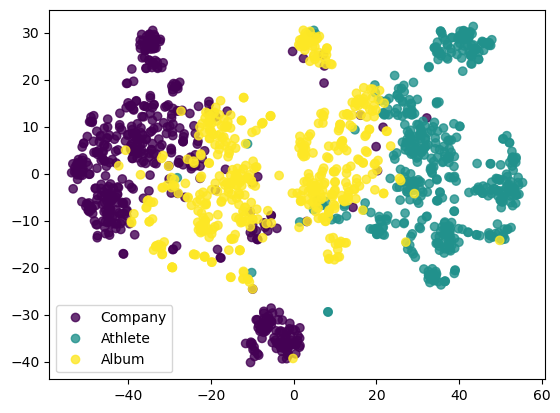

In [23]:
plot_tsne(vectors, labels, perplexity=30.0, n_iter=1000)

Take a moment to consider how you would interpret the results; you will need this for the reflection part.

## Problem 2: Sentence embeddings

In Problem 1, we extracted embeddings for one specific _word_; how do we obtain embeddings that represent an entire _sentence_?

There are multiple ways to go about this. A technique that can be applied to any model is to simply take the _average of all word vectors_ in a sentence. For BERT-style models, we can do something simpler: we can use the representation from the special `[CLS]` token that is placed at the beginning of each sentence. The model is trained in such a way that the representation for this token should encapsulate the overall content of the input sentence.

Use your implementation from Task&nbsp;1.1 to extract _sentence embeddings_ for each sentence in the data set, so that they can be plotted with your t-SNE implementation from Task&nbsp;1.2.  After running the following cell, `sentence_vectors` should contain one embedding for each sentence in the dataset.

In [24]:
%%time
token = '[CLS]'
sentence_vectors = extract_embeddings(df.sentence, token)
# YOUR CODE HERE
# raise NotImplementedError()

CPU times: total: 297 ms
Wall time: 15.3 s


In [25]:
sentence_vectors = np.asarray(sentence_vectors)

### 🤞 Test your code

If your implementation is correct, running the following cell should produce a scatterplot with the sentence vectors, which should look different from the one you obtained in Task&nbsp;1.2:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.000s...
[t-SNE] Computed neighbors for 1500 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 2.198856
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.340195
[t-SNE] KL divergence after 1000 iterations: 1.316857


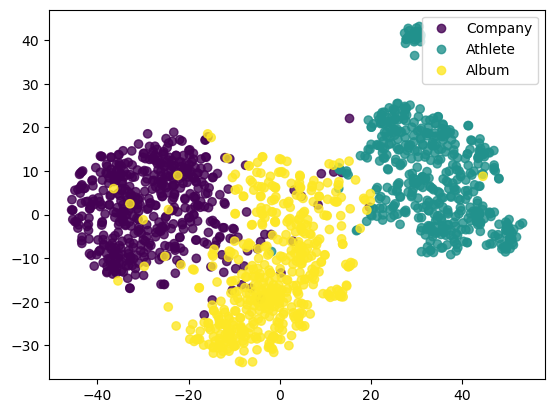

In [26]:
plot_tsne(sentence_vectors, labels, perplexity=30.0, n_iter=1000)

## Data set for summarization

In the remainder of this lab, we will look specifically at the task of text summarization. For this, we are using a subset of the CNN/DailyMail&nbsp;3.0.0 data set, a popular data set for summarization composed of news articles.

In [27]:
with bz2.open("cnn_dailymail_3.0.0_shorts.json.bz2", "rt", encoding="utf-8") as f:
    news_df = pd.read_json(f)

The dataset contains 5,000 news articles, but since some of the techniques we will explore here can be quite compute-intensive (depending on the hardware used to run this lab), we limit ourselves to a selection of ten articles for the exercises. You are welcome (and encouraged!) to inspect and run your code with other articles from the dataset too, but you should only use this small subset for the submitted solutions.

There are two labelled columns in the data set: `article` (the full news article), and `highlights` (highlights from the article, which we will treat as a “reference summary”).

In [28]:
indices = [6, 53, 56, 340, 730, 1940, 1983, 2404, 2826, 4673]
short_news_df = news_df.iloc[indices]
short_news_df[:3]

,article,highlights
6,"Former French President Nicolas Sarkozy was called in for questioning Tuesday as part of a corruption investigation in connection with an inquiry into alleged abuse of power. Financial prosecutor Eliane Houlette confirmed that Sarkozy was called in around 8 a.m. local time by police in Nanterre. Investigators have been looking into Sarkozy's campaign financing, CNN's French affiliate BFMTV reported. They are trying to establish whether the former President, who led the country from 2007 to 2012, obtained confidential information on legal cases concerning him from top magistrates in exchange for the offer of a prestigious post, the channel said. Under French law, Sarkozy can be held for questioning for a day, which can be extended once by another 24 hours. The situation is unprecedented for a former president, BFMTV reported. His lawyer, Thierry Herzog, and two high-ranking magistrates were called in for questioning in the Paris area Monday, according to BFMTV. Their police custody was extended by another 24 hours Tuesday. Sarkozy left office in May 2012 after he lost in the presidential election to Socialist rival Francois Hollande. In recent months, speculation has grown that he might be positioning himself for a political comeback at the head of his center-right party, the UMP. CNN's Jim Bittermann reported from Paris and Laura Smith-Spark wrote in London.","Former French President Nicolas Sarkozy is called in for questioning, prosecutor says . Investigators have been looking into Sarkozy's campaign financing . They want to establish if he obtained secret information about cases concerning him ."
53,"Thailand's King Bhumibol Adulyadej has been hospitalized with a high fever and irregular blood pressure, the palace said Saturday. The king, who was admitted to a hospital in Bangkok on Friday evening, appeared to be improving. ""On Saturday morning, his medical team announced that after being administered antibiotics intravenously, his blood pressure stabilized and his fever dropped,"" the palace said in a statement. The 86-year-old is a member of the Chakri dynasty, which has occupied the Thai throne since the 18th century. The U.S.-born and Swiss-educated king is a deeply revered figure whose unifying appeal stretches across all elements of Thai society, from the rich urban elite to poor provincial farmers. He ascended to the throne in 1946, and has reigned over more than 20 prime ministers, 17 military coups and 17 constitutions. CNN's Kocha Olarn reported from Bangkok, and Faith Karimi wrote and reported from Atlanta.",The king was admitted to a hospital in Bangkok . He has reigned over more than 20 prime ministers .
56,"A Disney Cruise Line employee has been reported missing during a seven-day cruise off the Mexico's Pacific coast, the company said Thursday. The unidentified worker on board the Disney Wonder failed to appear for a Tuesday shift, Disney spokeswoman Christi Erwin Donnan said. The vessel, which left Los Angeles on Sunday, docked Wednesday in Puerto Vallarta, Mexico, Donnan said. The U.S. Coast Guard, the Mexican navy and the Bahamas Maritime Authority have participated in the search and investigation, Donnan said. The Disney Wonder is registered in the Bahamas. The Mexican navy has been conducting searches since Tuesday, Disney Cruise Line said in a written statement. ""Given the circumstances, we are very concerned about this situation and are doing everything possible to assist with the search effort and investigation,"" it said. The company said it conducted a thorough inspection of the cruise ship. U.S. Coast Guard Petty Officer Pamela Manns said the Mexican navy is leading the search and asked for Coast Guard help early in the effort. The Coast Guard provided long-range search aircraft but is not now actively involved in the search. The FBI is not involved because it does not have jurisdiction, as the ship was off the coast of Mexico flying under a foreign flag, said spokeswoman La

## Problem 3: Extractive summarization

In this problem, we will produce a summary of a news article by extracting a small number of sentences from it.

### Task 3.1: Extracting sentence embeddings

In the data set, each news article is given as a single string, so we first need to split it up into sentences before we can compute the sentence embeddings.  Your first task is to implement this with the help of spaCy.

In [29]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [30]:
def get_sentences_and_embeddings(text):
    """Splits the text into sentences and computes embeddings for each of them.

    Arguments:
        text: The text to process, e.g. an entire news article.

    Returns:
        A tuple (sentences, sentence_vectors).  `sentences` should be a list of 
        sentences from the text, while `sentence_vectors` should be a list of
        embedding vectors corresponding to these sentences.
    """  
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    token = '[CLS]'
    sentence_vectors = extract_embeddings(sentences, token)

    return((sentences,sentence_vectors))
    
    # YOUR CODE HERE
    # raise NotImplementedError()

#### 🤞 Test your code

The following cell shows how your function should be called, and sanity-checks the returned value for the first news article: 

In [31]:
sents, vecs = get_sentences_and_embeddings(short_news_df.iloc[2]["article"])
assert len(sents) == len(vecs) == 13, "The news article should produce 13 sentences and, therefore, 13 vectors"
assert sents[4] == 'The Disney Wonder is registered in the Bahamas.', "The fifth sentence in the article is 'The Disney Wonder is registered in the Bahamas.'"
assert np.isclose(np.asarray(vecs).mean(), -0.0617, atol=1e-04), "Average of all vectors should be approximately -0.0617"
success()

### Task 3.2: Extractive summarization with MMR

You now have all the necessary inputs to produce an extractive summary of a news article. Write a function that takes a list of sentences and their corresponding embedding vectors, as well as a number of sentences to extract from it. Your function should then implement the **maximum marginal relevance (MMR) algorithm** as follows:

1. Initially, your candidate set $C$ contains all sentences in the news article, and the set of selected sentences $S$ is empty.
2. As the “profile vector” $p$, use the **centroid** of all the sentence vectors from the news article.
3. Pick the next sentence to extract from $C\backslash S$ using the marginal relevance formula:

$$
s_i = \textrm{arg\,max}_{s \in C\backslash S} ~\left( \textrm{sim}(s, p) - \textrm{max}_{s_j \in S} ~\textrm{sim}(s, s_j) \right)
$$

In this formula, “sim” is the plain **cosine similarity** between the vectors.  We recommend you use the [`cosine_similarity` function from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) for this purpose.

4. Repeat step 3 until you have extracted $n$ sentences, where $n$ is given as an argument to your function.

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

def extractive_summary(sentences, vectors, n=3):
    """Produce an extractive summary from a list of sentences and their vectors.

    Arguments:
        sentences (list): A list of sentences.
        vectors (list): A list of vectors, one for each sentence.
        n (int): The number of sentences to extract for the summary.

    Returns:
        A summary of `n` extracted sentences, as a single string.
    """
    # YOUR CODE HERE
    sentences = np.asarray(sentences)
    vectors = np.asarray(vectors)
    centroid = np.mean(vecs,axis=0)
    p = centroid

    idxS = [] #index of selected 
    res = [] # summary
    for j in range(n):        
        S = sentences[idxS]
        SV = vectors[idxS]
        mask = np.ones(sentences.shape, dtype=bool)
        mask[idxS] = False
        RS = sentences[mask] # not selected
        RSV = vectors[mask]
        mmr = -np.Inf
        for i,s in enumerate(RSV):
            if len(SV) >0:
                mr = cosine_similarity([s],[p]) - \
                    np.max([cosine_similarity([s],[vec])[0][0] for vec in SV])
            else:
                mr = cosine_similarity([s],[p])
            if mr > mmr:
                mmr = mr
                selectIdx = i
                
        # print(j)
        # print("len(SV):  ",len(SV))
        # print("mask",mask)
        # print("S",S)
        # print("RS",RS)
        # print("selectIdx",selectIdx)
        # print("RS[selectIdx]",RS[selectIdx])
        fullIdxSelect = np.where(mask)[0][selectIdx]
        idxS.append(fullIdxSelect)
        res.append(RS[selectIdx])
    
        # print("idxS",idxS)
        # print("res:   ",res)
        # print("-------")

    # print(res.shape)
    return " ".join(res)



    # raise NotImplementedError()

#### 🤞 Test your code

The following cell puts it all together: it extracts the sentences and embeddings for one news article, generates the extractive summary, and displays it:

In [33]:
#test 
# vectors = np.asarray(vecs)
# centroid = np.mean(vecs,axis=0)
# p = centroid
# SV = vectors[0]
# [cosine_similarity([vec],[p])[0][0] for vec in SV]

In [34]:
news = short_news_df.iloc[3]
sents, vecs = get_sentences_and_embeddings(news["article"])
summary = extractive_summary(sents, vecs, n=3)

# Show the article, highlights, and extracted summary in a table
pd.DataFrame({
    "article": [news["article"]],
    "highlights": [news["highlights"]],
    "summary": [summary]
})

,article,highlights,summary
0,"Blackpool have announced that their former goalkeeper Iain Hesford has passed away at the age of 54. Hesford made his debut for the Seasiders in 1977 before going on to play for Sunderland and Hull in a career which spanned three decades. Most of his time was spent at Blackpool and he made more than 200 league appearances in six years at Bloomfield Road. Former goalkeeper Iain Hesford, pictured playing for Hesford, has died at the age of 54 . 'Condolences go out to his family at this sad time,' said a statement on the Sky Bet Championship club's official website. In a statement on their website, Hull said: 'The Club was saddened on Thursday to learn of the death of former goalkeeper Iain Hesford at the age of 54. Our thoughts are with Iain’s family at this sad time.' Hesford (back row, centre), pictured in a Hull team photo, also played for Hull, Blackpool and Sunderland .",Iain Hesford made over 200 league appearances for Blackpool . He also played for Hull and Sunderland among other clubs . The former goalkeeper has passed away at the age of 54 .,"Blackpool have announced that their former goalkeeper Iain Hesford has passed away at the age of 54. 'Condolences go out to his family at this sad time,' said a statement on the Sky Bet Championship club's official website. Hesford made his debut for the Seasiders in 1977 before going on to play for Sunderland and Hull in a career which spanned three decades."


If your implementation is correct, your summary should look like this:

> Blackpool have announced that their former goalkeeper Iain Hesford has passed away at the age of 54. 'Condolences go out to his family at this sad time,' said a statement on the Sky Bet Championship club's official website. Hesford made his debut for the Seasiders in 1977 before going on to play for Sunderland and Hull in a career which spanned three decades.

Try it out with different news articles to see what happens!

## Problem 4: Evaluation of summarization

In this problem, you implement a ROUGE metric to automatically compare the extracted summaries against the “highlights” column of the data set.

### Task 4.1: Implementing ROUGE-2

Concretely, you should implement **ROUGE-2**, which is the version of the ROUGE metric based on bigram overlap between a system output and a reference.  In our case, the “system output” is the (concatenated) string of sentences from the generated summary, while the “reference” is the `highlights` column from the news data set.  The ROUGE-2 score is the F1-score computed from the **number of overlapping bigrams** compared against the **total number of bigrams** in the system output and the reference.

You will need to tokenize the inputs in order to compute the bigram overlap. Different tokenizers may result in different ROUGE scores. For the purpose of this problem, **you should use spaCy to tokenize your input.**  If in doubt, you can refer to [the spaCy 101 documentation on tokenization](https://spacy.io/usage/spacy-101#annotations-token).


In [35]:
def str2gram2(text):
    doc = nlp(text)
    tokens =[]
    for token in doc:
        tokens.append(token.text)
    tokens

    gram2 = []
    for i,token in enumerate(tokens[:-1]):
        gram2.append((str(tokens[i]), tokens[i+1]))

    set(gram2)
    
    return set(gram2)

def evaluation_scores(gold, pred):
    """Print precision, recall, and F1 score.
    
    Arguments:
        gold: The set with the gold-standard values.
        pred: The set with the predicted values.
    
    Returns:
        A tuple or list containing the precision, recall, and F1 values
        (in that order), computed based on the specified sets.
    """
    # YOUR CODE HERE
    # minlen = min(len(gold), len(pred))  
    # tp = np.sum(np.asarray(list(gold))[:minlen] == np.asarray(list(pred))[:minlen])
    tp = len(pred &gold)

    precision = tp/len(pred)
    # tp/p (positive pred)
    recall = tp/len(gold)
    # tp/(tp + fn) (positive obs)
    F1 = 2*precision*recall/(precision+recall+1e-30)

    return F1
    # raise NotImplementedError()

def rouge_2(system, reference):
    """Compute the ROUGE-2 score between a system output and a reference.
    
    Arguments:
        system (str): The system output, as a single string.
        reference (str): The reference to compare against, as a single string.

    Returns:
        The F1-score of the ROUGE-2 metric between system output and reference.
    """
    gram2_sys = str2gram2(system)
    gram2_ref = str2gram2(reference)
    return evaluation_scores(gram2_ref , gram2_sys)

    
    # YOUR CODE HERE
    # raise NotImplementedError()


In [36]:
#test
# system, reference = "System output.", "Reference summary."
# gram2_sys = str2gram2(system)
# gram2_ref = str2gram2(reference)
# evaluation_scores(gram2_ref , gram2_sys)
# # gold, pred = gram2_ref , gram2_sys
# # tp = len(pred &gold)
# # tp
# # 1e-15
# rouge_2("Two identical strings.", "Two identical strings.")

In [37]:
#test
system, reference = news["highlights"], summary
# doc = nlp(system)
# tokens =[]
# for token in doc:
#     tokens.append(token.text)
# tokens

# gram2 = []
# for i,token in enumerate(tokens[:-1]):
#     gram2.append((tokens[i], tokens[i+1]))
# set(gram2)

gram2_sys = str2gram2(system)
gram2_ref = str2gram2(reference)
# evaluation_scores(gram2_ref , gram2_sys)
gold, pred = gram2_ref , gram2_sys
tp = len(pred &gold)
tp



precision = tp/len(pred)
precision
# tp/p (positive pred)
recall = tp/len(gold)
recall
# tp/(tp + fn) (positive obs)
F1 = 2*precision*recall/(precision+recall)

#### 🤞 Test your code

The following cell tests your implementation of ROUGE-2 with some toy examples:

In [38]:
assert rouge_2("System output.", "Reference summary.") == 0.0, "Two strings without any bigram overlap should return a score of zero"
assert rouge_2("Two identical strings.", "Two identical strings.") == 1.0, "Two identical strings should return a score of one"
assert rouge_2("This is my summary.", "This is the summary.") == 0.5, "In this example, when using the correct tokenization, exactly half of the bigrams overlap, so the ROUGE-2 score should be 0.5"
success()

### Task 4.2: Evaluating extractive summarization against a baseline

Now that you have an implementation of an evaluation metric, you can use it to evaluate the extractive summaries on the small set of news articles in `short_news_df`.

After running the following cell:
- `extractive` should contain the extractive summaries for all articles in `short_news_df`, one summary per article, with **two sentences per summary**.
- `extractive_rouge_2` should contain the average ROUGE-2 score for the extractive summaries, when evaluated against the "highlights" column in `short_news_df`.

In [39]:

extractive = []           # Summaries of all articles in `short_news_df`
for text in short_news_df.article:
    sents, vecs =get_sentences_and_embeddings(text)
    summary = extractive_summary(sents, vecs, n=2)
    extractive.append(summary)

r2scrs = []
for i,reference in enumerate(short_news_df.highlights):
    system = extractive[i]
    r2scr = rouge_2(system, reference)
    r2scrs.append(r2scr)

extractive_rouge_2 = np.mean(r2scrs)   # Average ROUGE-2 score


# YOUR CODE HERE
# raise NotImplementedError()

In [40]:
#test
extractive_rouge_2
# extractive[0]
# short_news_df.highlights.iloc[0]
# pd.DataFrame({"ref":short_news_df.highlights, 'exr':extractive})

# news = short_news_df.iloc[3]
# sents, vecs = get_sentences_and_embeddings(news["article"])

# [news for news in short_news_df ]  
# len(extractive)
# short_news_df.shape

0.17061781289289013

We cannot say much about the ROUGE-2 score unless we compare it against a **baseline**.  A simple baseline for text summarization is to just take the first $n$&nbsp;sentences from the article.  In the following cell, you should compute the ROUGE-2 score of this baseline, i.e., taking the **first two sentences** of the article as your “summary”.

In [41]:
extractive = []           # Summaries of all articles in `short_news_df`
for text in short_news_df.article:
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    # summary = sentences[:2]
    summary = " ".join(sentences[:2])
    extractive.append(summary)

r2scrs = []
for i,reference in enumerate(short_news_df.highlights):
    system = extractive[i]
    r2scr = rouge_2(system, reference)
    r2scrs.append(r2scr)



baseline_rouge_2 = np.mean(r2scrs)     # Average ROUGE-2 score of baseline
# YOUR CODE HERE
# raise NotImplementedError()

In [42]:
#test
baseline_rouge_2
# text = short_news_df.article.iloc[-1]
# doc = nlp(text)
# sentences = [sent.text for sent in doc.sents]
# " ".join(sentences[:2])


0.1455825934109885

#### 🤞 Test your code

The following cell prints both ROUGE-2 scores:

In [43]:
print(f"ROUGE-2 (baseline)  : {baseline_rouge_2:.4f}")
print(f"ROUGE-2 (extractive): {extractive_rouge_2:.4f}")

ROUGE-2 (baseline)  : 0.1456
ROUGE-2 (extractive): 0.1706


## Problem 5: Abstractive summarization

Finally, we will turn to _abstractive_ summarization, for which we will use a distilled version of a large language model that can be run on CPU.  Concretely, we will run a quantized version of Orca-Mini-3B, which is loaded in the following cell.

Please note:

- **If you are running this on the LiU computers,** the following cell will use the model file that we already downloaded to a shared course folder.
- **If you are running this on your own computer,** the following cell will automatically download the model from Huggingface the first time you run it, which **requires approx.&nbsp;2.4&nbsp;GB of disk space!**

In [44]:
import os
from ctransformers import AutoModelForCausalLM, AutoTokenizer

# Path to the model on the LiU computers
model_name = "/courses/TDDE16/models/q5_0-orca-mini-3b.gguf"

if os.path.exists(model_name):
    # Running on the LiU computers
    model_file = model_name
else:
    # *NOT* running on the LiU computers
    model_name = "Aryanne/Orca-Mini-3B-gguf"
    model_file = "q5_0-orca-mini-3b.gguf"

print(f"Using model: {model_name}")


Using model: Aryanne/Orca-Mini-3B-gguf


In [45]:
orca_model = AutoModelForCausalLM.from_pretrained(model_name, model_file=model_file, model_type="llama", gpu_layers=0, hf=True)
orca_tokenizer = AutoTokenizer.from_pretrained(orca_model)

Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Similar as before, we will define a pipeline to interact with our model, but instead of a `feature-extraction` pipeline, we use a `text-generation` pipeline. We also add a `TextStreamer` to our pipeline, which prints the generated text already while it is being generated.  Let's run it on a toy example just to see if it works:

In [46]:
from transformers import pipeline, TextStreamer

streamer = TextStreamer(orca_tokenizer)
generate = pipeline("text-generation", model=orca_model, tokenizer=orca_tokenizer, streamer=streamer)
output = generate("Linköping is a city in", max_new_tokens=23)

Linköping is a city in the southern part of Sweden, located on the east coast of the country, facing the Kattegat sea.


### Task 5.1: Prompt construction

The Orca models were fine-tuned on a specific _input prompt format_ that looks like this:

```
### System: You are an AI assistant that follows instruction extremely well.
### Human:
Write a poem about text mining.
### Assistant:
```

The text that follows `### System:` is a _system instruction_ that tells the model “how to behave.”  The text following `### Human:` is the _human input_, i.e. the actual question we want the model to answer, or task that we want the model to solve.  The prompt ends with `### Assistant:` as an indication that this is where the model-generated text begins.

We can run this exact prompt through the model as follows _(feel free to try it with different prompts)_:

In [47]:
prompt = """### System: You are an AI assistant that follows instruction extremely well.
### Human:
Write a poem about text mining.
### Assistant:
"""
output = generate(prompt, max_new_tokens=150)

### System: You are an AI assistant that follows instruction extremely well.
### Human:
Write a poem about text mining.
### Assistant:
 Text mining, an art we pursue,
A world of words we've unlocked,
From scribbles to insights we've found,
The meaning in messages we've made.
We parse the text, we clean the data,
We extract the gems, we don't confuse,
We analyze the trends, we forecast the scenes,
We uncover the secrets, we leave no stone unturned.
Text mining, a vast and endless frontier,
A world of stories we've yet to tell,
We read the text, we write the song,
We make the world a more textured place.


Your first task here is to **construct a prompt for text summarization** and test it by running it on one of the news articles.

In [135]:
def make_prompt_for_summarization(text):
    """Construct a prompt that instructs the model to summarize a text.

    Arguments:
        text (str): The text to summarize.

    Returns:
        A prompt to feed into an Orca model.
    """
    prompt = f"""### System: You are an AI assistant that follows instruction extremely well. You summarize the news text given to you and output a shorter version of news. Be short! In one line!
    ### Human:
    {text}
    ### Assistant:
    """
    return prompt
    # YOUR CODE HERE
    # raise NotImplementedError()

#### 🤞 Test your code

Test your prompt by running the following cell. It should generate a summary of the first news article in `short_news_df`.

In [136]:
prompt = make_prompt_for_summarization(short_news_df.iloc[0]["article"])
output = generate(prompt, max_new_tokens=150)

8:00 AM: Nicolas Sarkozy was called in for questioning by police in Nanterre, France. He is being investigated for campaign financing and abuse of power. His lawyer and two high-ranking magistrates were also called in for questioning. The situation is unprecedented for a former president.


### Task 5.2: Generating the abstractive summaries & evaluating

We have everything in place that's needed to generate the abstractive summaries, compute their ROUGE-2 scores against the "highlights" column, and compare the results against both the baseline and the extractive summaries. Let's implement that in the following cell. 

Since we will be generating output for several news articles at once, we set `streamer.skip_prompt = True` in order to make it only output the generated text, rather than the entire prompt.

After running the following cell:
- `abstractive` should contain the abstractive summaries for all articles in `short_news_df`, one summary per article.  Note that you should _only append the generated summaries_, not including the prompt!
- `abstractive_rouge_2` should contain the average ROUGE-2 score for the abstractive summaries, when evaluated against the "highlights" column.

<i>Note:</i> This cell should take the longest time to run out of all exercises in this notebook; in our testing, it took around 3–5 minutes on the lab computers.

In [137]:
%%time

streamer.skip_prompt = True  # This prevents TextStreamer from printing the entire prompt each time
abstractive = []             # Summaries of all articles in `short_news_df`
for text in short_news_df.article:
    prompt = make_prompt_for_summarization(text)
    output = generate(prompt, max_new_tokens=150)
    abstra = list(output[0].values())[0].split("### Assistant:")[1].strip()
    abstractive.append(abstra)

r2scrs = []
for i,reference in enumerate(short_news_df.highlights):
    system = abstractive[i]
    r2scr = rouge_2(system, reference)
    r2scrs.append(r2scr)

abstractive_rouge_2 = np.mean(r2scrs)    # Average ROUGE-2 score
# YOUR CODE HERE
# raise NotImplementedError()

8:00 AM: Nicolas Sarkozy was called in for questioning by police in Nanterre, France. He is being investigated for campaign financing and abuse of power. His lawyer and two high-ranking magistrates were also called in for questioning. The situation is unprecedented for a former president.
1. Thailand's King Bhumibol Adulyadej has been hospitalised with a high fever and irregular blood pressure.
    2. His medical team has announced that his blood pressure stabilized and his fever dropped after being administered antibiotics.
    3. The king is a member of the Chakri dynasty and has been on the throne since 1946.
    4. He has been a deeply revered figure across all elements of Thai society.
    5. CNN's Kocha Olarn reported from Bangkok and Faith Karimi wrote and reported from Atlanta.
1. A Disney Cruise Line employee has been reported missing during a seven-day cruise off the Mexico's Pacific coast.
    2. The unidentified worker on board the Disney Wonder failed to appear for a Tuesd

Number of tokens (513) exceeded maximum context length (512).


Number of tokens (514) exceeded maximum context length (512).


Number of tokens (515) exceeded maximum context length (512).


Number of tokens (516) exceeded maximum context length (512).


 
54-year-old Iain Hesford, who played for Blackpool, Sunderland, Hull and other clubs, has passed away. He made his debut for Blackpool in 1977 and went on to play for Sunderland and Hull in a career that spanned three decades. Most of his time was spent at Blackpool, where he made more than 200 league appearances in six years at Bloomfield Road. The club's official website confirmed his passing, with condolences going out to his family at this sad time.
2015-2016 Premier League season will start on August 8. England manager Roy Hodgson may have additional time to prepare his side for Euro 2016. The FA Cup third round will be the first fixture to be played next year due to the scheduling of the Euros and Champions League final. The date for the final day of the season has yet to be announced.
1. United Airlines flight from Chicago to Frankfurt, Germany, was diverted to Toronto this week after the pilot dumped a cup of coffee on the plane's communication's equipment.
    2. The unwante

Number of tokens (513) exceeded maximum context length (512).


led 

Number of tokens (514) exceeded maximum context length (512).


to 

Number of tokens (515) exceeded maximum context length (512).


the 

Number of tokens (516) exceeded maximum context length (512).


led 

Number of tokens (517) exceeded maximum context length (512).


to 

Number of tokens (518) exceeded maximum context length (512).


the 

Number of tokens (519) exceeded maximum context length (512).


led 

Number of tokens (520) exceeded maximum context length (512).


to 

Number of tokens (521) exceeded maximum context length (512).


the 

Number of tokens (522) exceeded maximum context length (512).


led 

Number of tokens (523) exceeded maximum context length (512).


to 

Number of tokens (524) exceeded maximum context length (512).


the 

Number of tokens (525) exceeded maximum context length (512).


led 

Number of tokens (526) exceeded maximum context length (512).


to 

Number of tokens (527) exceeded maximum context length (512).


the 

Number of tokens (528) exceeded maximum context length (512).


led 

Number of tokens (529) exceeded maximum context length (512).


to 

Number of tokens (530) exceeded maximum context length (512).


the 

Number of tokens (531) exceeded maximum context length (512).


led 

Number of tokens (532) exceeded maximum context length (512).


to 

Number of tokens (533) exceeded maximum context length (512).


the led
1. Secretary of Defense Leon Panetta is expected to announce this week that same-sex spouses of service members will be granted some benefits that they had been denied until now.
    2. Sources in the gay activist community have received indications that the announcement could come this week.
    3. The Pentagon has been reviewing what benefits it could extend without violating the Defense of Marriage Act.
    4. Gay rights groups have been calling for the change.
    5. Among the benefits gay rights groups say can be legally extended are housing on military bases, military ID cards to access on-base activities and programs, access to commissaries and the consideration of a same-sex
39 people were killed when a passenger plane crashed in Tehran on Sunday. The Antonov-140 propeller plane went down shortly after leaving the runway at Mehrabad International Airport after an engine failed, according to official news agencies in Iran. The FARS semiofficial news agency reported that 

Number of tokens (513) exceeded maximum context length (512).
Number of tokens (514) exceeded maximum context length (512).


killed, 

Number of tokens (515) exceeded maximum context length (512).


including 

Number of tokens (516) exceeded maximum context length (512).


the 

Number of tokens (517) exceeded maximum context length (512).


plane 

Number of tokens (518) exceeded maximum context length (512).


was 

Number of tokens (519) exceeded maximum context length (512).
Number of tokens (520) exceeded maximum context length (512).


killed, 

Number of tokens (521) exceeded maximum context length (512).


including 

Number of tokens (522) exceeded maximum context length (512).


the 

Number of tokens (523) exceeded maximum context length (512).


plane 

Number of tokens (524) exceeded maximum context length (512).


was 

Number of tokens (525) exceeded maximum context length (512).
Number of tokens (526) exceeded maximum context length (512).


killed, 

Number of tokens (527) exceeded maximum context length (512).


including 

Number of tokens (528) exceeded maximum context length (512).


the 

Number of tokens (529) exceeded maximum context length (512).


plane 

Number of tokens (530) exceeded maximum context length (512).


was 

Number of tokens (531) exceeded maximum context length (512).
Number of tokens (532) exceeded maximum context length (512).


killed, 

Number of tokens (533) exceeded maximum context length (512).


including the
2020-09-28 Bolivian President Evo Morales on Sunday pledged to continue his hunger strike until Monday, when Congress, including the opposition-led Senate, is set to reconvene.
42-year-old Neil Lennon has stepped down from his role as Celtic manager after leading the club to three Scottish Premiership titles during his four-year spell in charge. His former team-mate Henrik Larsson is one of the front runners for the post.
CPU times: total: 14min 34s
Wall time: 3min 52s


#### 🤞 Test your code

The following cell prints all ROUGE-2 scores, and the cell after that displays a table with the highlights and generated summaries, side-by-side:

In [139]:
print(f"ROUGE-2 (baseline)   : {baseline_rouge_2:.4f}")
print(f"ROUGE-2 (extractive) : {extractive_rouge_2:.4f}")
print(f"ROUGE-2 (abstractive): {abstractive_rouge_2:.4f}")

ROUGE-2 (baseline)   : 0.1456
ROUGE-2 (extractive) : 0.1706
ROUGE-2 (abstractive): 0.1633


In [140]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame({
    "highlights": short_news_df.loc[:, "highlights"],
    "extractive": extractive,
    "abstractive": abstractive
})

,highlights,extractive,abstractive
6,"Former French President Nicolas Sarkozy is called in for questioning, prosecutor says . Investigators have been looking into Sarkozy's campaign financing . They want to establish if he obtained secret information about cases concerning him .",Former French President Nicolas Sarkozy was called in for questioning Tuesday as part of a corruption investigation in connection with an inquiry into alleged abuse of power. Financial prosecutor Eliane Houlette confirmed that Sarkozy was called in around 8 a.m. local time by police in Nanterre.,"8:00 AM: Nicolas Sarkozy was called in for questioning by police in Nanterre, France. He is being investigated for campaign financing and abuse of power. His lawyer and two high-ranking magistrates were also called in for questioning. The situation is unprecedented for a former president."
53,The king was admitted to a hospital in Bangkok . He has reigned over more than 20 prime ministers .,"Thailand's King Bhumibol Adulyadej has been hospitalized with a high fever and irregular blood pressure, the palace said Saturday. The king, who was admitted to a hospital in Bangkok on Friday evening, appeared to be improving.",1. Thailand's King Bhumibol Adulyadej has been hospitalised with a high fever and irregular blood pressure.\n 2. His medical team has announced that his blood pressure stabilized and his fever dropped after being administered antibiotics.\n 3. The king is a member of the Chakri dynasty and has been on the throne since 1946.\n 4. He has been a deeply revered figure across all elements of Thai society.\n 5. CNN's Kocha Olarn reported from Bangkok and Faith Karimi wrote and reported from Atlanta.
56,A cruise line employee has not been seen since Tuesday . Disney Wonder left Los Angeles on Sunday . Mexican navy and Bahamas Maritime Authority are involved in search .,"A Disney Cruise Line employee has been reported missing during a seven-day cruise off the Mexico's Pacific coast, the company said Thursday. The unidentified worker on board the Disney Wonder failed to appear for a Tuesday shift, Disney spokeswoman Christi Erwin Donnan said.","1. A Disney Cruise Line employee has been reported missing during a seven-day cruise off the Mexico's Pacific coast.\n 2. The unidentified worker on board the Disney Wonder failed to appear for a Tuesday shift.\n 3. The vessel, which left Los Angeles on Sunday, docked Wednesday in Puerto Vallarta, Mexico.\n 4. The U.S. Coast Guard, the Mexican navy and the Bahamas Maritime Authority have participated in the search and investigation.\n 5. The Disney Wonder is registered in the Bahamas.\n 6. The Mexican navy has been conducting searches since Tuesday."
340,Iain Hesford made over 200 league appearances for Blackpool . He also played for Hull and Sunderland among other clubs . The former goalkeeper has passed away at the age of 54 .,Blackpool have announced that their former goalkeeper Iain Hesford has passed away at the age of 54. Hesford made his debut for the Seasiders in 1977 before going on to play for Sunderland and Hull in a career which spanned three decades.,"54-year-old Iain Hesford, who played for Blackpool, Sunderland, Hull and other clubs, has passed away. He made his debut for Blackpool in 1977 and went on to play for Sunderland and Hull in a career that spanned three decades. Most of his time was spent at Blackpool, where he made more than 200 league appearances in six years at Bloomfield Road. The club's official website confirmed his passing, with condolences going out to his family at this sad time."
730,The earliest the Premier League season has ever begun is August 7 . The next Premier League campaign will kick off on August 8 . The move could give England more time to prepare for Euro 2016 .,"The Premier League has announced that next season's competition will begin on August 8. The Barclays Premier League season will be followed by the European Championship, and the Premier League's move could allo

### Task 5.3: Sampling from the probability distribution

By default, the generated text is produced using _greedy search_, which simply picks the most likely candidate word each time. This means running the generation pipeline multiple times will result in the exact same generated text each time.  We can instead use a search strategy that _samples_ from the probability distribution, by setting `do_sample=True` when calling the pipeline.  Several parameters can be used to influence the sampling process, one of which is `temperature`, which is a float that is set to `0.8` by default.

Run the following cell multiple times with different values for the `temperature` parameter, and observe if/how the results change.  We recommend that you try out values for temperature in the range $(0, 3)$ and run the generation multiple times with each temperature value.

In [141]:
# TODO: Try out different values for the "temperate" parameter here
parameters = dict(do_sample=True, temperature=0.8)

# Running the text generator on an example article
prompt = make_prompt_for_summarization(short_news_df.iloc[3]["article"])
output = generate(prompt, max_new_tokens=150, **parameters)

54 is the age of Iain Hesford, the goalkeeper who passed away at Blackpool, Hull, and Sunderland. He made his debut for Blackpool in 1977 and spent 11 years playing for the club, before joining Hull and Sunderland. He also played for the national team.


There is no answer/solution for you to provide in this task, but the reflection part of the lab will refer to this task.

**Congratulations on finishing this lab! 👍**

<div class="alert alert-info">
    
➡️ Don't forget to **test that everything runs as expected** before you submit!

</div>